In [22]:
import xml.etree.ElementTree as ET
from xml.etree.ElementTree import Element
from lxml import etree
from copy import copy
import os
import inspect
from xml.dom import minidom
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
this_folder = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
this_folder

'/Users/jseverin/Athena/NREL_github/ATHENA-siem-sumo/Sumo/Simulations'

# Building out the xml for the SUMO trips file

In [4]:
xroutes = Element('routes')
xroutes.set('xmlns:xsi','http://www.w3.org/2001/XMLSchema-instance')
xroutes.set('xsi:noNamespaceSchemaLocation', 'http://sumo.dlr.de/xsd/routes_file.xsd')
# Additing vehicle type definition for truck and trailer

vtype = Element('vType')
vtype.set('id', 'truck')
vtype.set('vClass', 'truck')
xroutes.append(vtype)
vtype1 = Element('vType')
vtype1.set('id', 'trailer')
vtype1.set('vClass', 'trailer')
xroutes.append(vtype1)
vtype2 = Element('vType')
vtype2.set('id', 'passenger')
vtype2.set('vClass', 'passenger')
xroutes.append(vtype2)
vtype3 = Element('vType')
vtype3.set('id', 'bus')
vtype3.set('vClass', 'bus')
xroutes.append(vtype3)

In [5]:
start = ['South_Plaza','North_Plaza']
end = ['South_Exit','North_Exit']
stops = ['Terminal_A_Top','Terminal_B_Top','Terminal_C_Top','Terminal_D_Top','Terminal_E_Top',
        'Terminal_A_Bottom','Terminal_B_Bottom','Terminal_C_Bottom','Terminal_D_Bottom','Terminal_E_Bottom',
        'none']

### Below is the first trial code of building out a demand model over the different terminals

In [6]:
for t in range(10000):
    if random.uniform(0, 1) > .6:  # 40% of the time a car is being added to the DFW area
        
        if random.uniform(0, 1) > .55: #45% of the time a vehicle is coming from the North Plaza
            tripS = start[1] #North Plaza
            if random.uniform(0,1) > .2: #80% of the time, it leaves the opposite side it came from
                tripE = end[0] #South Plaza
            else:
                tripE = end[1] #North Plaza
        else:
            tripS = start[0]
            if random.uniform(0,1) > .2:
                tripE = end[1] #North Plaza
            else:
                tripE = end[0] #South Plaza
    
    
        curb_stop = random.choice(stops) #uniform distribution on terminal stops
        try:
            a = curb_stop.split('_')
            new = a[0] + a[1] + a[2]
        except:
            pass

        trip = Element('trip')
        trip.set('id', str(t))
        trip.set('type', 'passenger')
        trip.set('depart',str(float(t)))
        trip.set('from',tripS)
        trip.set('to',tripE)
        xroutes.append(trip)
    
        if curb_stop == "none":
            pass
        else:
            ET.SubElement(trip, "stop",busStop=new,duration="60") #duration is in seconds for stop time
    
        

In [7]:
test = 'Terminal_A_Top'
a = test.split('_')
new = a[0] + a[1] +a[2]
new

'TerminalATop'

In [8]:

file_name = 'trips.xml'
print("Saving to xml: ", file_name)
configfile = os.path.join(this_folder, file_name)
with open(configfile, 'wb') as f:
    f.write(minidom.parseString(ET.tostring(xroutes)).toprettyxml(encoding="utf-8"))
    

Saving to xml:  trips.xml


In [9]:
additional = Element('additional')
additional.set('xmlns:xsi','http://www.w3.org/2001/XMLSchema-instance')
additional.set('xsi:noNamespaceSchemaLocation', "http://sumo.dlr.de/xsd/additional_file.xsd")
# Additing vehicle type definition for truck and trailer

for s in stops:
    if s != "none":
        a = s.split('_')
        new = a[0] + a[1] + a[2]
        print(s)
        ID = s + "_0"
        busStop = Element('busStop')
        busStop.set('id', new)
        busStop.set('lane', ID)
        busStop.set('friendlyPos','1')
        busStop.set('lines','1')
        busStop.set('startPos','0')
        busStop.set('endPos','500')

        additional.append(busStop)
file_name = 'additional2.xml'
print("Saving to xml: ", file_name)
configfile = os.path.join(this_folder, file_name)
with open(configfile, 'wb') as f:
    f.write(minidom.parseString(ET.tostring(additional)).toprettyxml(encoding="utf-8"))
    

Terminal_A_Top
Terminal_B_Top
Terminal_C_Top
Terminal_D_Top
Terminal_E_Top
Terminal_A_Bottom
Terminal_B_Bottom
Terminal_C_Bottom
Terminal_D_Bottom
Terminal_E_Bottom
Saving to xml:  additional2.xml


# Generating Demand from flight data model


In [10]:
demand = pd.read_csv('athena_sumo_v1.csv')

In [11]:
demand.head()

,scheduled_fight_time,parking,pass,A,B,C,D,E,time,month,day,year
0,2017-10-01 00:00:00,15.0,33.0,43,24,48,28,3,00:00:00,10,1,2017
1,2017-10-01 00:30:00,23.0,21.0,25,14,27,13,2,00:30:00,10,1,2017
2,2017-10-01 01:00:00,15.0,15.0,13,7,14,7,1,01:00:00,10,1,2017
3,2017-10-01 01:30:00,11.0,10.0,12,7,14,6,1,01:30:00,10,1,2017
4,2017-10-01 02:00:00,11.0,12.0,14,8,14,9,1,02:00:00,10,1,2017


In [28]:
def month(string):
    string = string.lower()
    if string.startswith( 'jan' ):
        month = 1
    elif string.startswith( 'feb' ):
        month = 2
    elif string.startswith( 'mar' ):
        month = 3
    elif string.startswith( 'apr' ):
        month = 4
    elif string.startswith( 'may' ):
        month = 5
    elif string.startswith( 'jun' ):
        month = 6
    elif string.startswith( 'jul' ):
        month = 7
    elif string.startswith( 'aug' ):
        month = 8
    elif string.startswith( 'sep' ):
        month = 9
    elif string.startswith( 'oct' ):
        month = 10
    elif string.startswith( 'nov' ):
        month = 11
    elif string.startswith( 'dec' ):
        month = 12
    else:
        print("Sorry – wrong input. Try another month")

    return month
        
def day(string):
    string = string.lower()
    if string.startswith('mon'):
        day = 0
    elif string.startswith('tue'):
        day = 1
    elif string.startswith('wed'):
        day = 2
    elif string.startswith('thu'):
        day = 3
    elif string.startswith('fri'):
        day = 4
    elif string.startswith('sat'):
        day = 5
    elif string.startswith('sun'):
        day = 6
    else:
        print('Sorry – wrong day of week inputed')
    return day

In [12]:
from datetime import datetime
dw = []
for i, row in enumerate(demand['scheduled_fight_time']):
    today = datetime_object = datetime.strptime(row, '%Y-%m-%d %H:%M:%S')
    dow = today.weekday() 
    dw.append(dow)
demand['day_of_week'] = dw #adding a column day of week

In [13]:

demand['total_pass'] = demand[['parking','pass','A','B','C','D','E']].sum(axis=1) # aggregating across the terminals

In [14]:
demand.head()

,scheduled_fight_time,parking,pass,A,B,C,D,E,time,month,day,year,day_of_week,total_pass
0,2017-10-01 00:00:00,15.0,33.0,43,24,48,28,3,00:00:00,10,1,2017,6,194.0
1,2017-10-01 00:30:00,23.0,21.0,25,14,27,13,2,00:30:00,10,1,2017,6,125.0
2,2017-10-01 01:00:00,15.0,15.0,13,7,14,7,1,01:00:00,10,1,2017,6,72.0
3,2017-10-01 01:30:00,11.0,10.0,12,7,14,6,1,01:30:00,10,1,2017,6,61.0
4,2017-10-01 02:00:00,11.0,12.0,14,8,14,9,1,02:00:00,10,1,2017,6,69.0


In [15]:

date = []
for i, row in enumerate(demand['scheduled_fight_time']):
    date.append(row.split()[0])
demand['date'] = date # adding a date without timestamp column to aggregate over

In [16]:
day_df = demand.groupby('date').sum()
sorted_top10 = day_df.sort_values(['total_pass']).tail(10)
sorted_bott10 = day_df.sort_values(['total_pass']).head(10)


# Top 10 highest Volume days - Aggregated over the day


In [17]:
sorted_top10[['parking','pass','A','B','C','D','E','total_pass']]

,parking,pass,A,B,C,D,E,total_pass
date,,,,,,,,
2018-07-16,14800.0,4597.0,15364,8582,17241,8433,1006,70023.0
2018-06-07,13179.0,6108.0,15694,8652,17223,8198,1059,70113.0
2018-05-21,14632.0,5737.0,15262,8544,17273,8050,1015,70513.0
2018-06-25,15134.0,4901.0,15470,8775,17528,8382,1026,71216.0
2018-07-09,15050.0,4619.0,15654,8644,17640,8648,1032,71287.0
2018-06-18,15485.0,4553.0,15688,8716,17600,8656,1055,71753.0
2018-07-13,11614.0,5080.0,16880,9317,19035,8994,1136,72056.0
2018-06-08,11948.0,5648.0,16888,9476,18658,9202,1147,72967.0
2018-06-11,15339.0,5010.0,16152,9018,18089,8610,1088,73306.0


# Bottom 10 Volume Days

In [18]:
sorted_bott10[['parking','pass','A','B','C','D','E','total_pass']]

,parking,pass,A,B,C,D,E,total_pass
date,,,,,,,,
2018-03-31,5041.0,2981.0,7472,4161,8425,4002,513,32595.0
2018-02-03,5829.0,2927.0,8129,4515,9005,4368,554,35327.0
2018-01-20,5723.0,2864.0,8528,4719,9275,4543,582,36234.0
2018-04-07,5969.0,3001.0,8621,4920,9751,4662,574,37498.0
2018-01-27,5515.0,4752.0,8339,4704,9342,4365,552,37569.0
2017-11-24,4715.0,3200.0,9049,5047,10410,4923,617,37961.0
2017-12-02,6219.0,3532.0,8606,4815,9728,4520,579,37999.0
2017-12-31,5215.0,1675.0,9562,5394,10707,5088,648,38289.0
2017-11-23,6305.0,3086.0,8935,5017,9908,4945,589,38785.0


# Showing all data

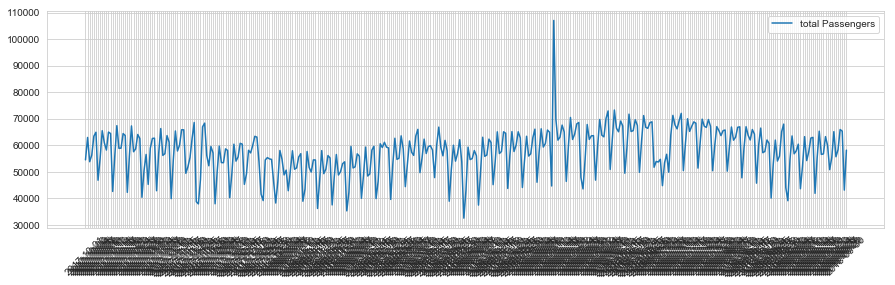

In [23]:
plt.figure(figsize=(15,4))
sns.set_style("whitegrid")

plt.plot(day_df.index,day_df['total_pass'],label='total Passengers')
plt.xticks(rotation=45)

plt.legend()
plt.show()

# Looking for highest and lowest volume by Day of the week

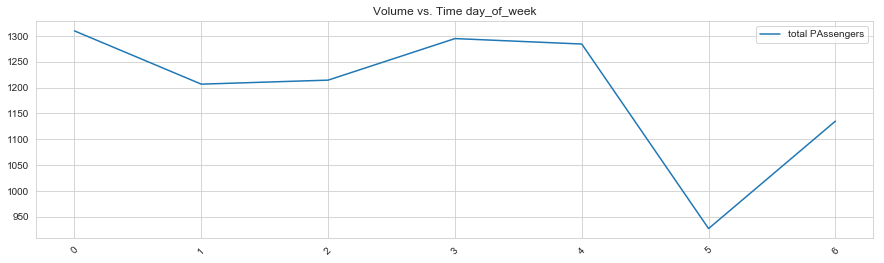

In [24]:
col = 'day_of_week'
agg_dow = demand.groupby(col).mean()
plt.figure(figsize=(15,4))
sns.set_style("whitegrid")

plt.plot(agg_dow.index,agg_dow['total_pass'],label='total PAssengers')
plt.xticks(rotation=45)
plt.title("Volume vs. Time {}".format(col))
plt.legend()
plt.show()

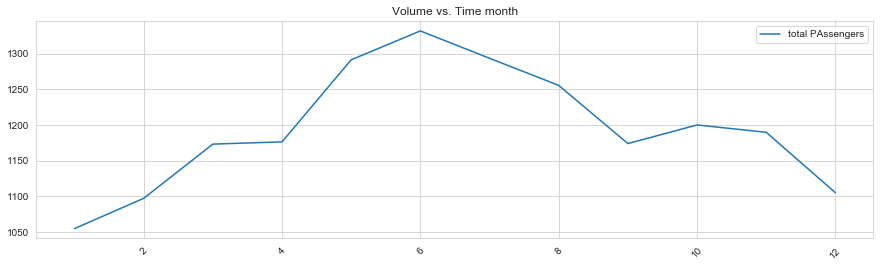

In [25]:
col = 'month'
agg_dow = demand.groupby(col).mean()
plt.figure(figsize=(15,4))
sns.set_style("whitegrid")

plt.plot(agg_dow.index,agg_dow['total_pass'],label='total PAssengers')
plt.xticks(rotation=45)
plt.title("Volume vs. Time {}".format(col))
plt.legend()
plt.show()

In [29]:
demand['day_of_week'].unique()


array([6, 0, 1, 2, 3, 4, 5])

In [30]:
def avg_day_month(d,m):
    d = day(d)
    m = month(m)
    agg = demand.loc[(demand['month'] == m) & (demand['day_of_week'] == d)]
    agg = agg.groupby('time').mean()
    return agg

In [31]:
def top_day_month(d,m,p):
    d = day(d)
    m = month(m)
    agg = demand.loc[(demand['month'] == m) & (demand['day_of_week'] == d)]
    agg = agg.groupby('time').quantile(q=p)
    return agg

d = "Monday"
m = "June"
df = top_day_month(d,m,.95)
df.head(10)

0.95,parking,pass,A,B,C,D,E,month,day,year,day_of_week,total_pass
time,,,,,,,,,,,,
00:00:00,15.95,29.55,169.70,97.40,189.75,105.85,11.00,6.0,23.95,2018.0,0.0,601.85
00:30:00,13.25,22.55,154.60,79.30,178.20,78.70,8.85,6.0,23.95,2018.0,0.0,530.50
01:00:00,19.10,20.25,94.20,52.10,113.15,62.60,6.70,6.0,23.95,2018.0,0.0,357.90
01:30:00,9.85,21.55,76.25,42.60,88.75,39.10,4.70,6.0,23.95,2018.0,0.0,280.30
02:00:00,18.00,13.70,54.10,32.45,63.75,28.60,3.70,6.0,23.95,2018.0,0.0,211.55
02:30:00,50.65,22.70,43.25,21.85,48.70,22.70,3.00,6.0,23.95,2018.0,0.0,203.00
03:00:00,112.80,24.55,59.25,32.40,62.55,30.10,3.85,6.0,23.95,2018.0,0.0,320.70
03:30:00,243.65,36.10,112.55,66.95,121.55,59.80,7.00,6.0,23.95,2018.0,0.0,616.20
04:00:00,363.50,30.95,168.95,92.70,183.80,109.00,10.85,6.0,23.95,2018.0,0.0,933.40


In [32]:
d = "Sunday"
m = "December"
df_low = top_day_month(d,m,.05)
df_low.head(10)

0.05,parking,pass,A,B,C,D,E,month,day,year,day_of_week,total_pass
time,,,,,,,,,,,,
00:00:00,3.6,19.6,51.8,27.0,49.8,25.0,3.2,12.0,4.4,2017.0,6.0,194.8
00:30:00,5.2,15.8,24.8,13.6,28.2,11.2,1.2,12.0,4.4,2017.0,6.0,105.2
01:00:00,6.2,10.4,21.4,12.0,24.0,12.4,1.2,12.0,4.4,2017.0,6.0,89.8
01:30:00,5.2,10.2,16.2,9.0,19.0,9.0,1.0,12.0,4.4,2017.0,6.0,75.8
02:00:00,5.6,9.0,13.4,7.4,14.6,7.0,1.0,12.0,4.4,2017.0,6.0,59.2
02:30:00,20.6,7.2,16.4,8.6,18.8,8.4,1.0,12.0,4.4,2017.0,6.0,85.2
03:00:00,59.8,9.6,32.4,17.4,36.2,16.4,2.2,12.0,4.4,2017.0,6.0,179.6
03:30:00,119.8,16.2,61.4,33.4,63.2,31.8,4.0,12.0,4.4,2017.0,6.0,331.0
04:00:00,179.4,16.0,101.4,51.4,107.4,47.6,7.0,12.0,4.4,2017.0,6.0,523.8


# Plotting the Volume by terminal over time

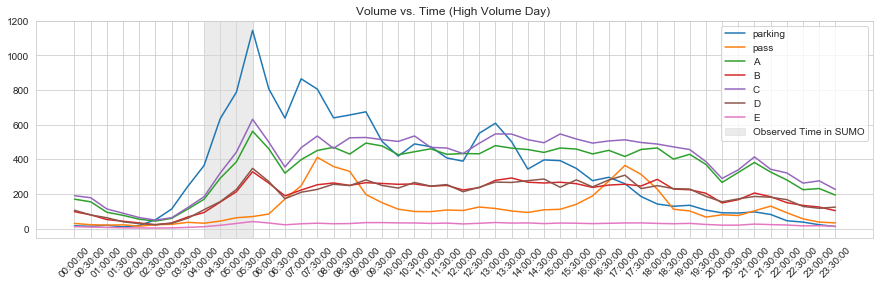

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(15,4))

sns.set_style("whitegrid")
cols = ['parking','pass','A','B','C','D','E']


for c in cols:
    plt.plot(df.index,df[c],label=c)
plt.axvspan(df.index[8],df.index[11], alpha=0.5, color='#d8d8d8',label="Observed Time in SUMO")


plt.xticks(rotation=45)
plt.title("Volume vs. Time (High Volume Day) ")
plt.legend(loc='upper right')
plt.show()

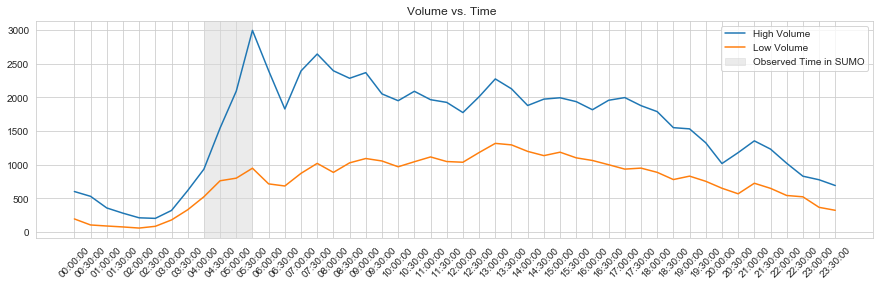

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(15,4))

sns.set_style("whitegrid")
plt.plot(df.index,df['total_pass'],label="High Volume")
plt.plot(df_low.index,df_low['total_pass'],label="Low Volume")
plt.axvspan(df.index[8],df.index[11], alpha=0.5, color='#d8d8d8',label="Observed Time in SUMO")


plt.xticks(rotation=45)
plt.title("Volume vs. Time  ")
plt.legend(loc='upper right')
plt.show()

In [38]:
df['total_pass'].sum()

74883.70000000001

In [39]:
routes_custom = Element('routes')
routes_custom.set('xmlns:xsi','http://www.w3.org/2001/XMLSchema-instance')
routes_custom.set('xsi:noNamespaceSchemaLocation', 'http://sumo.dlr.de/xsd/routes_file.xsd')
# Additing vehicle type definition for truck and trailer





In [40]:
terminal_dict = {
    "A":['A_top_1','A_top_2','A_bot'],
    "B":['B_top_1','B_top_2','B_top_3','B_bot'],
    "C":['C_top_1','C_top_2','C_bot'],
    "D":['D_top_1','D_top_2','D_bot'],
    "E":['E_top_1','E_top_2','E_top_3','E_bot'],
    "parking":['Park_n','Park_s','Park_f'],
    "pass":"pass_through"
}
stop_dict = {
    "A":['A_top_1','A_top_2','A_bot'],
    "B":['B_top_1','B_top_2','B_top_3','B_bot'],
    "C":['C_top_1','C_top_2','C_bot'],
    "D":['D_top_1','D_top_2','D_bot'],
    "E":['E_top_1','E_top_2','E_top_3','E_bot']
}

In [41]:
scaler = 0
hhr = 60*30
counter = 0
for t, time in enumerate(df.index):
    interval = [scaler,(scaler+hhr)]
    scaler+=hhr
    
    for c in cols:
        vol = int(df.iloc[t][c])
        sample_t = np.around(np.random.uniform(interval[0],interval[1],vol))
        #print(c,terminal_dict[c],vol)
        for s in sample_t:
            counter +=1
            if c == "parking" or c == "pass":
                boolean = 1
            else:
                boolean = 0
            if c == "pass":
              
                
                if random.uniform(0, 1) > .4:
                    #coming from the North
                    start = "North_Plaza"
                    if random.uniform(0,1) >.2:
                        #80% of the time they leave the opposite they came
                        end = "South_Exit"
                    else:
                        end = "North_Exit"
                else:
                    #coming form the South
                    start = "South_Plaza"
                    if random.uniform(0,1) > .2:
                        end = "North_Exit"
                    else:
                        end = "South_Exit"
            elif c == "parking":
                if random.uniform(0, 1) > .4:
                    #coming from the North
                    start = "North_Plaza"
                    
                else:
                    #coming form the South
                    start = "South_Plaza"
                end = random.choice(terminal_dict[c])
                
            else:
                
               
                if random.uniform(0, 1) > .4:
                    #coming from the North
                    start = "North_Plaza"
                    if random.uniform(0,1) >.2:
                        #80% of the time they leave the same they came
                        end = "North_Exit"
                    else:
                        end = "South_Exit"
                else:
                    #coming form the South
                    start = "South_Plaza"
                    if random.uniform(0,1) > .2:
                        end = "South_Exit"
                    else:
                        end = "North_Exit"
                
                stop = random.choice(terminal_dict[c])
                
            if c == "parking":
                #print("yellow")
                color = "0,0,255" #Blue as above in plot
            elif c == "pass":
                color = "249, 179, 49" # orange
            elif c == "A":
                color = "16, 135, 40" # green
            elif c == "B":
                color = "216, 2, 16" # red
            elif c == "C":
                color = "124, 85, 135" # purple
            elif c == "D":
                color = "119, 100, 25" # brown
            else:
                color = "255, 130, 171" # pink
            r = 1000*round(np.random.uniform(0,1),4)
            trip = Element('trip')
            trip.set('id', (str(counter)+c))
            trip.set('type', 'passenger')
            trip.set('color', color)
            trip.set('depart',str(s))
            trip.set('from',start)
            trip.set('to',end)
            routes_custom.append(trip)
            duration = str(int(np.random.uniform(20,40)))
            if boolean == 0:
                #print(c)
                ET.SubElement(trip, "stop",busStop=stop,duration=duration)
            
routes_custom[:] = sorted(routes_custom, key=lambda child: (child.tag,float(child.get('depart'))))
            


file_name = 'trip_custom.xml'
print("Saving to xml: ", file_name)
configfile = os.path.join(this_folder, file_name)
with open(configfile, 'wb') as f:
    f.write(minidom.parseString(ET.tostring(routes_custom)).toprettyxml(encoding="utf-8"))
            
    

Saving to xml:  trip_custom.xml


In [42]:
additional = Element('additional')
additional.set('xmlns:xsi','http://www.w3.org/2001/XMLSchema-instance')
additional.set('xsi:noNamespaceSchemaLocation', "http://sumo.dlr.de/xsd/additional_file.xsd")
# Additing vehicle type definition for truck and trailer

vtype = Element('vType')
vtype.set('id', 'truck')
vtype.set('vClass', 'truck')
additional.append(vtype)
vtype1 = Element('vType')
vtype1.set('id', 'trailer')
vtype1.set('vClass', 'trailer')
additional.append(vtype1)
vtype2 = Element('vType')
vtype2.set('id', 'passenger')
vtype2.set('vClass', 'passenger')
additional.append(vtype2)
vtype3 = Element('vType')
vtype3.set('id', 'bus')
vtype3.set('vClass', 'bus')
additional.append(vtype3)
for s in stop_dict.keys():
    
    print(type(s))
    for ind in stop_dict[s]:
        print(ind)
        lane = ind + "_0"
        
        busStop = Element('busStop')
        busStop.set('id', ind)
        busStop.set('lane', lane)
        busStop.set('friendlyPos','1')
        busStop.set('lines','1')
        busStop.set('startPos','0')
        busStop.set('endPos','1500')

        additional.append(busStop)
file_name = 'additional_custom.xml'
print("Saving to xml: ", file_name)
configfile = os.path.join(this_folder, file_name)
with open(configfile, 'wb') as f:
    f.write(minidom.parseString(ET.tostring(additional)).toprettyxml(encoding="utf-8"))
    

<class 'str'>
A_top_1
A_top_2
A_bot
<class 'str'>
B_top_1
B_top_2
B_top_3
B_bot
<class 'str'>
C_top_1
C_top_2
C_bot
<class 'str'>
D_top_1
D_top_2
D_bot
<class 'str'>
E_top_1
E_top_2
E_top_3
E_bot
Saving to xml:  additional_custom.xml


# Trip Output

In [43]:
trip_df = pd.read_csv("trip_output.csv", sep=';')

In [44]:
trip_df.head()

,tripinfo_arrival,tripinfo_arrivalLane,tripinfo_arrivalPos,tripinfo_arrivalSpeed,tripinfo_depart,tripinfo_departDelay,tripinfo_departLane,tripinfo_departPos,tripinfo_departSpeed,tripinfo_devices,...,tripinfo_id,tripinfo_rerouteNo,tripinfo_routeLength,tripinfo_speedFactor,tripinfo_stopTime,tripinfo_timeLoss,tripinfo_vType,tripinfo_vaporized,tripinfo_waitingCount,tripinfo_waitingTime
0,286.0,Park_s_0,265.15,21.21,59.0,10.0,North_Plaza_0,5.1,0.0,tripinfo_9parking routing_9parking,...,9parking,1,5037.28,0.98,0.0,16.49,passenger,NaN,0,0.0
1,305.0,North_Exit_0,112.07,16.01,14.0,0.0,North_Plaza_0,5.1,0.0,tripinfo_48A routing_48A,...,48A,1,5791.20,1.08,22.0,38.63,passenger,NaN,1,2.0
2,327.0,North_Exit_0,112.07,16.11,17.0,1.0,North_Plaza_0,5.1,0.0,tripinfo_159A routing_159A,...,159A,1,5734.47,1.03,35.0,34.52,passenger,NaN,1,2.0
3,335.0,Park_s_0,265.15,23.98,161.0,2.0,South_Plaza_0,5.1,0.0,tripinfo_15parking routing_15parking,...,15parking,1,3895.52,1.10,0.0,18.97,passenger,NaN,0,0.0
4,336.0,North_Exit_0,112.07,13.88,211.0,1.0,North_Plaza_0,5.1,0.0,tripinfo_30pass routing_30pass,...,30pass,1,1926.87,0.91,0.0,28.04,passenger,NaN,0,0.0


In [45]:
trip_df.shape

(82243, 21)

In [46]:
trip_df.columns.tolist()

['tripinfo_arrival',
 'tripinfo_arrivalLane',
 'tripinfo_arrivalPos',
 'tripinfo_arrivalSpeed',
 'tripinfo_depart',
 'tripinfo_departDelay',
 'tripinfo_departLane',
 'tripinfo_departPos',
 'tripinfo_departSpeed',
 'tripinfo_devices',
 'tripinfo_duration',
 'tripinfo_id',
 'tripinfo_rerouteNo',
 'tripinfo_routeLength',
 'tripinfo_speedFactor',
 'tripinfo_stopTime',
 'tripinfo_timeLoss',
 'tripinfo_vType',
 'tripinfo_vaporized',
 'tripinfo_waitingCount',
 'tripinfo_waitingTime']

In [47]:

import re
st = "1434234fljsd34234flj"
word1 = "".join(re.findall("[a-zA-Z]+", st))
word1

'fljsdflj'

In [49]:
ttype = []
for i, row in enumerate(trip_df['tripinfo_id']):
    string = "".join(re.findall("[a-zA-Z]+", row))
    ttype.append(string)
    
trip_df['ttype'] = ttype #extracting the type of trip it was (i.e. "A" means terminal A trip)

In [50]:
type_trip = ['A','B','C','D','E','parking','pass']
data = {}
for t in type_trip:
    col = []
    for i, tt in enumerate(trip_df['ttype']):
        if tt == t and trip_df['tripinfo_duration'][i] <600:
            col.append(trip_df['tripinfo_duration'][i])
    data[t] = col

# Distributions of Trip duration

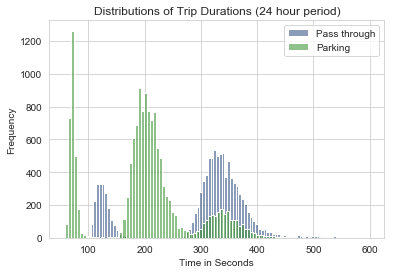

In [51]:

plt.hist(data['pass'], bins=100, color="#32518290", label="Pass through")
plt.hist(data['parking'], bins=100, color="#39913290", label="Parking")
plt.title('Distributions of Trip Durations (24 hour period)')
plt.ylabel('Frequency')
plt.xlabel('Time in Seconds')
plt.legend()
plt.show()


In [52]:
type_trip = ['A','B','C','D','E']
data2 = {}
for t in type_trip:
    col = []
    for i, tt in enumerate(trip_df['ttype']):
        if tt == t and trip_df['tripinfo_duration'][i] <2000:
            col.append(trip_df['tripinfo_duration'][i])
    data2[t] = col

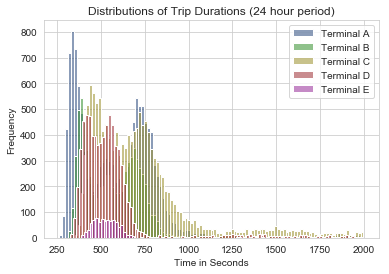

In [53]:
plt.hist(data2['A'], bins=100, color="#32518290", label="Terminal A")
plt.hist(data2['B'], bins=100, color="#39913290", label="Terminal B")
plt.hist(data2['C'], bins=100, color="#9e933290", label="Terminal C")
plt.hist(data2['D'], bins=100, color="#a0333a90", label="Terminal D")
plt.hist(data2['E'], bins=100, color="#99309b90", label="Terminal E")

plt.title('Distributions of Trip Durations (24 hour period)')
plt.ylabel('Frequency')
plt.xlabel('Time in Seconds')
plt.legend()
plt.show()

# Emissions ouptputs for low volume and high volume days

In [54]:
f_top = pd.read_csv('fuel_top.csv', sep=';')
f_bot = pd.read_csv('fuel_bot.csv', sep=';')
s_top = pd.read_csv('summary_top.csv', sep=';')
s_bot = pd.read_csv('summary_bot.csv', sep=';')

In [55]:
f_top.head()

,timestep_time,vehicle_CO,vehicle_CO2,vehicle_HC,vehicle_NOx,vehicle_PMx,vehicle_angle,vehicle_eclass,vehicle_electricity,vehicle_fuel,vehicle_id,vehicle_lane,vehicle_noise,vehicle_pos,vehicle_route,vehicle_speed,vehicle_type,vehicle_waiting,vehicle_x,vehicle_y
0,0.0,164.78,2624.72,0.81,1.20,0.07,359.03,HBEFA3/PC_G_EU4,0.0,1.13,521D,South_Plaza_0,55.94,5.10,!521D!var#1,0.00,passenger,0.0,1972.47,454.83
1,1.0,148.04,2955.05,0.74,1.32,0.07,359.03,HBEFA3/PC_G_EU4,0.0,1.27,521D,South_Plaza_0,62.52,6.48,!521D!var#1,1.38,passenger,0.0,1972.45,456.20
2,2.0,133.26,3267.70,0.68,1.43,0.07,359.03,HBEFA3/PC_G_EU4,0.0,1.40,521D,South_Plaza_0,62.85,9.18,!521D!var#1,2.70,passenger,0.0,1972.40,458.91
3,3.0,164.78,2624.72,0.81,1.20,0.07,359.03,HBEFA3/PC_G_EU4,0.0,1.13,47A,South_Plaza_0,55.94,5.10,!47A!var#1,0.00,passenger,0.0,1972.47,454.83
4,3.0,122.40,3775.14,0.65,1.63,0.08,359.03,HBEFA3/PC_G_EU4,0.0,1.62,521D,South_Plaza_0,63.95,13.32,!521D!var#1,4.14,passenger,0.0,1972.34,463.05


In [56]:
f_top['vehicle_lane'].unique()

array(['South_Plaza_0', 'North_Plaza_0', ':5362984631_1_0', ...,
       ':4058337301_0_0', ':5088672444_0_0', nan], dtype=object)

In [57]:
ttype = []
for i, row in enumerate(f_top['vehicle_id']):
    try:
        string = "".join(re.findall("[a-zA-Z]+", row))
        ttype.append(string)
    except:
        ttype.append(string)
f_top['ttype'] = ttype

In [58]:
type_trip = ['A','B','C','D','E','parking','pass']
fuel = {}
for t in type_trip:
    col = []
    for i, tt in enumerate(f_top['ttype']):
        if tt == t :
            col.append((f_top['vehicle_fuel'][i]*0.951019))
    fuel[t] = col

/Users/jseverin/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/jseverin/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


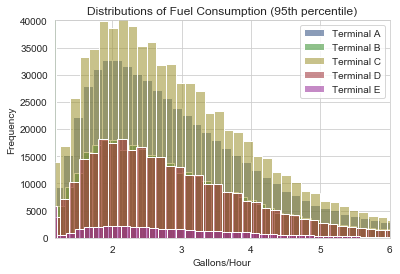

In [59]:
plt.hist(fuel['A'], bins=100, color="#32518290", label="Terminal A")
plt.hist(fuel['B'], bins=100, color="#39913290", label="Terminal B")
plt.hist(fuel['C'], bins=100, color="#9e933290", label="Terminal C")
plt.hist(fuel['D'], bins=100, color="#a0333a90", label="Terminal D")
plt.hist(fuel['E'], bins=100, color="#99309b90", label="Terminal E")

plt.title('Distributions of Fuel Consumption (95th percentile)')
plt.ylabel('Frequency')
plt.xlabel('Gallons/Hour')
plt.xlim(1.17, 6)
plt.ylim(0, 40000)
plt.legend()
plt.show()

In [61]:
for f in fuel.keys():
    sum_arr = sum(fuel[f])
    print(f,": ",sum_arr, "gph" )

A :  1890813.1037184992 gph
B :  1087754.0011282675 gph
C :  nan gph
D :  1033389.7703189466 gph
E :  133453.53860091287 gph
parking :  1318337.991788163 gph
pass :  882084.8632944761 gph


In [62]:
ttype = []
for i, row in enumerate(f_bot['vehicle_id']):
    try:
        string = "".join(re.findall("[a-zA-Z]+", row))
        ttype.append(string)
    except:
        ttype.append(string)
f_bot['ttype'] = ttype

In [63]:
type_trip = ['A','B','C','D','E','parking','pass']
fuel2 = {}
time = {}
for t in type_trip:
    col = []
    t_col = []
    for i, tt in enumerate(f_bot['ttype']):
        if tt == t :
            t_col.append(f_bot['timestep_time'][i])
            col.append((f_bot['vehicle_fuel'][i]*0.951019))
    fuel2[t] = col
    time[t] = t_col

/Users/jseverin/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/jseverin/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


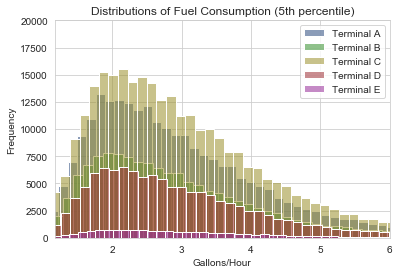

In [64]:
plt.hist(fuel2['A'], bins=100, color="#32518290", label="Terminal A")
plt.hist(fuel2['B'], bins=100, color="#39913290", label="Terminal B")
plt.hist(fuel2['C'], bins=100, color="#9e933290", label="Terminal C")
plt.hist(fuel2['D'], bins=100, color="#a0333a90", label="Terminal D")
plt.hist(fuel2['E'], bins=100, color="#99309b90", label="Terminal E")

plt.title('Distributions of Fuel Consumption (5th percentile)')
plt.ylabel('Frequency')
plt.xlabel('Gallons/Hour')
plt.xlim(1.17, 6)
plt.ylim(0, 20000)
plt.legend()
plt.show()

In [65]:
def group_time(csv):
   
    min30 = []
    min15 = []
    min1 = []
    
    count_min = 60
    step_min = 60
    for i, row in enumerate(csv['timestep_time']):
        
        if row >= count_min:
            count_min+=step_min
        min1.append(count_min)
        
    csv['1min'] = min1

    
    print('This one is done')

In [66]:
group_time(f_top)
group_time(f_bot)

This one is done
This one is done


In [67]:
def agg_vtype(emissions):   
    sum_stats = pd.DataFrame()
    pas_fuel = []
    t_fuel = []
    num_trk =[]
    num_pas = []
    time = []
    pas_f = 0
    trk_f = 0
    num_t = 0
    num_p = 0
    wait_t = 0
    wait_p = 0
    p_spd = []
    t_spd = []
    t_wait = []
    p_wait = []
    spd_p = []
    spd_t = []
    t = emissions['1min'][0]
    counter = set()
    for i, row in enumerate(emissions['1min']):
        if row == t:
            if emissions['vehicle_type'][i] == 'passenger':
                num_p+=1
                pas_f+=emissions['vehicle_fuel'][i]
                spd_p.append(emissions['vehicle_speed'][i])
                wait_p+=emissions['vehicle_waiting'][i]
            elif emissions['vehicle_type'][i] == 'trailer' or emissions['vehicle_type'][i] == 'truck':
                num_t+=1
                trk_f+=emissions['vehicle_fuel'][i]
                spd_t.append(emissions['vehicle_speed'][i])
                wait_t+=emissions['vehicle_waiting'][i]
        else:
            p_avg = np.mean(spd_p)
            t_avg = np.mean(spd_t)
            p_spd.append(p_avg)
            t_spd.append(t_avg)
            pas_fuel.append(pas_f) 
            t_fuel.append(trk_f) 
            num_trk.append(num_t)
            num_pas.append(num_p) 
            time.append(row)
            t_wait.append(wait_t)
            p_wait.append(wait_p)
            pas_f = 0
            trk_f = 0
            num_t = 0
            num_p = 0
            spd_p = []
            spd_t = []
        t = row
        if row%3600 == 0 and row not in counter:
            counter.add(row)
            print(str(row)," seconds have passed")
    sum_stats['time'] = time
    sum_stats['pas_fuel'] = pas_fuel
    sum_stats['t_fuel'] = t_fuel
    sum_stats['num_trk'] = num_trk
    sum_stats['num_pas'] = num_pas
    sum_stats['p_spd'] = p_spd
    sum_stats['t_spd'] = t_spd
    sum_stats['t_wait'] = t_wait
    sum_stats['p_wait'] = p_wait
    return sum_stats

In [68]:
agg_top = f_top.groupby('1min').sum()
agg_bot = f_bot.groupby('1min').sum()

In [69]:
agg_top.head()

,timestep_time,vehicle_CO,vehicle_CO2,vehicle_HC,vehicle_NOx,vehicle_PMx,vehicle_angle,vehicle_electricity,vehicle_fuel,vehicle_noise,vehicle_pos,vehicle_speed,vehicle_waiting,vehicle_x,vehicle_y
1min,,,,,,,,,,,,,,,
60,26143.0,55537.33,3579295.88,340.31,1474.30,75.17,183548.28,0.0,1538.69,46577.31,197912.44,12528.12,0.0,1267589.21,1995320.57
120,163918.0,95049.55,7389327.60,613.12,2943.24,149.50,381480.47,0.0,3176.33,122590.30,334378.49,36178.85,0.0,3293168.28,8074446.97
180,454548.0,167418.80,12631204.85,1071.44,5031.16,260.00,668852.09,0.0,5429.79,209377.96,478236.64,63488.69,1.0,5642206.85,14900232.56
240,938446.0,259010.40,18627697.44,1635.42,7462.13,387.30,957880.70,0.0,8007.44,308698.64,692231.80,91502.22,239.0,8389600.18,23087979.92
300,1567530.0,364245.74,23234299.01,2224.23,9368.45,482.74,1244455.80,0.0,9988.22,395379.83,869124.11,107774.54,2043.0,10956188.26,30537022.54


In [70]:
#this will take a few minutes
type_trip = ['A','B','C','D','E','parking','pass']
fuel2 = {}
time = {}
for t in type_trip:
    col = []
    t_col = []
    for i, tt in enumerate(f_top['ttype']):
        if tt == t :
            t_col.append(f_top['timestep_time'][i])
            col.append((f_top['vehicle_fuel'][i]*0.951019))
    fuel2[t] = col
    time[t] = t_col

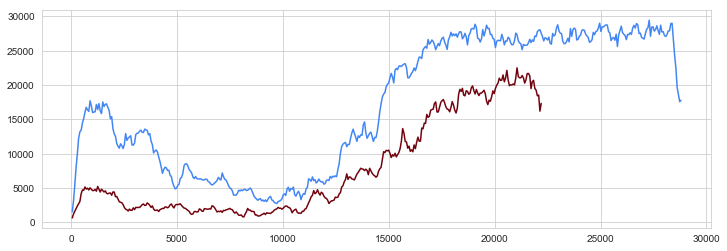

In [72]:
fig, ax = plt.subplots(figsize=(12,4))
plt.plot(agg_top['vehicle_fuel'].iloc[:480], color="#4286f4",label= "High Volume")
plt.plot(agg_bot['vehicle_fuel'].iloc[:370], color="#72030e",label= "Low Volume")
plt.legend
plt.show()

In [73]:
dict_type = {}
for t in type_trip:
    df_new = pd.DataFrame()
    df_new['time'] = time[t]
    df_new['fuel'] = fuel2[t]
    dict_type[t] = df_new

In [74]:
def group_time_ea(csv):
   
    min30 = []
    min15 = []
    min1 = []
    
    count_min = 60
    step_min = 60
    for i, row in enumerate(csv['time']):
        
        if row >= count_min:
            count_min+=step_min
        min1.append(count_min)
        
    csv['1min'] = min1



In [75]:
for d in dict_type.keys():
    group_time_ea(dict_type[d])
    
for d in dict_type.keys():
    dict_type[d] = dict_type[d].groupby('1min').sum()

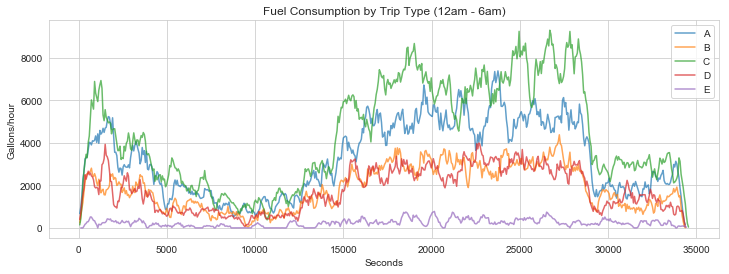

In [76]:
terminals = ['A','B','C','D','E']

fig, ax = plt.subplots(figsize=(12,4))
for d in terminals:
    plt.plot(dict_type[d]['fuel'], label=d, alpha= .7)
plt.title('Fuel Consumption by Trip Type (12am - 6am)')
plt.ylabel('Gallons/hour')
plt.xlabel('Seconds')
plt.legend()    
plt.show()

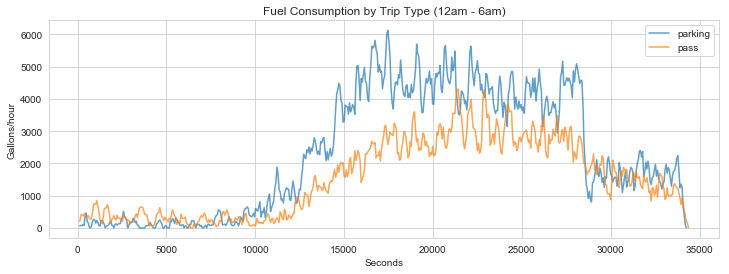

In [77]:
other = ['parking','pass']

fig, ax = plt.subplots(figsize=(12,4))
for d in other:
    plt.plot(dict_type[d]['fuel'], label=d, alpha=.7)
plt.title('Fuel Consumption by Trip Type (12am - 6am)')
plt.ylabel('Gallons/hour')
plt.xlabel('Seconds')
plt.legend()    
plt.show()